In [63]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [64]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [93]:
images = load_images_from_folder("/Users/justinli/Desktop/slot_attention/images/livecell_train_val_images")
images = load_images_from_folder("/Users/justinli/Desktop/slot_attention/images/livecell_test_images")

In [95]:
images = tf.convert_to_tensor(images)

In [99]:
images = images/255

In [153]:
images_train = images[0:1400]
images_train.shape

TensorShape([1400, 520, 704, 3])

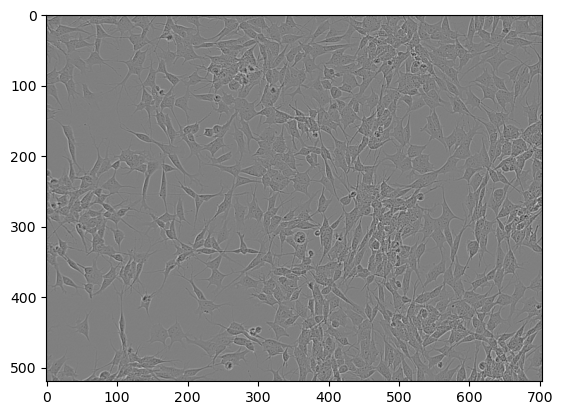

In [154]:
plt.imshow(images[0])

In [177]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

class Autoencoder(tf.keras.Model):
    def __init__(self, encoder1, encoder2, decoder1, decoder2, **kwargs):
        super().__init__(**kwargs)
        self.encoder1 = encoder1
        self.encoder2 = encoder2
        self.decoder1 = decoder1
        self.decoder2 = decoder2

    def call(self, inputs):
        enc1 = self.encoder1(inputs)
        enc2 = self.encoder2(enc1)
        dec1 = self.decoder1(enc2)
        dec2 = self.decoder2(dec1)
        return dec2


conv_kwargs = { 
    "padding"             : "SAME", 
    "activation"          : tf.keras.layers.LeakyReLU(alpha=0.2), 
    "kernel_initializer"  : tf.random_normal_initializer(stddev=.1)
}


ae_model = Autoencoder(
    encoder1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 2, strides=2, **conv_kwargs)  # (1400, 520, 704, 3) -> (1400, 260, 352, 8)
        # (filters(the number of channels), kernel_size(height and width of the 2D convolution window))

    ], name='encoder1'),

    encoder2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 2, strides=2, **conv_kwargs)  # (1400, 260, 352, 8) -> (1400, 130, 176, 16)
                                                                 # strides control the output shape for rows and columns 

    ], name='encoder2'),
        
    decoder1 = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(8, 2, strides=2, **conv_kwargs)  # (1400, 130, 176, 16) -> (1400, 260, 352, 8)


    ], name='decoder1'),

    decoder2 = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(3, 2, strides=2, **conv_kwargs)  # (1400, 260, 352, 8) -> (1400, 520, 704, 3)

    ], name='decoder2'),

name='autoencoder')

ae_model.build(input_shape = images_train.shape)   # required to see architecture summary
initial_weights = ae_model.get_weights() # just so we can reset out autoencoder

ae_model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder1 (Sequential)       (1400, 260, 352, 8)       104       
                                                                 
 encoder2 (Sequential)       (1400, 130, 176, 16)      528       
                                                                 
 decoder1 (Sequential)       (1400, 260, 352, 8)       520       
                                                                 
 decoder2 (Sequential)       (1400, 520, 704, 3)       99        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [178]:
from email.mime import image


ae_model.set_weights(initial_weights)  # resets model weights



mse_loss = tf.keras.losses.MeanSquaredError()     



def mseloss(*args, **kwargs):
  return mse_loss(*args, **kwargs) 

ae_model.compile(
    optimizer   = tf.keras.optimizers.Adam(learning_rate=0.001),
    # Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models
    loss        = mseloss,
    metrics     = tf.keras.metrics.MeanSquaredError()
        # a metric is a function that is used to judge the performance of your model
        # metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model   
)

history = ae_model.fit(
    images_train, images_train,   # inputs, labels (for autoencoder)
    epochs     = 10,
    batch_size = 20,
)

Epoch 1/10


2022-10-03 12:30:27.134556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 36s 443ms/step - loss: 0.1356 - mean_squared_error: 0.1356
Epoch 2/10
70/70 [==============================] - 25s 358ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 3/10
70/70 [==============================] - 25s 361ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 4/10
70/70 [==============================] - 23s 328ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 5/10
70/70 [==============================] - 20s 280ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 6/10
70/70 [==============================] - 36s 518ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 7/10
70/70 [==============================] - 28s 390ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 8/10
70/70 [==============================] - 25s 346ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 9/10
70/70 [==============================] - 29s 413ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 10/10


In [179]:
y = history.history['loss']
x = np.arange(10) + 1

/var/folders/4h/dwdjsw5n1ln0ngs7nflp8q2h0000gn/T/ipykernel_83809/863075580.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, '-ok', color='black')


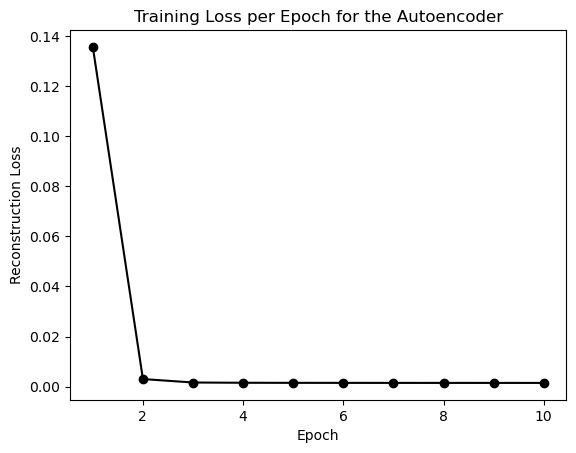

In [180]:
plt.plot(x, y, '-ok', color='black')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Training Loss per Epoch for the Autoencoder")
plt.show()

In [181]:
ae_model.evaluate(
    x = images[1401:],
    y = images[1401:]
)

2022-10-03 12:37:54.181340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 5s 262ms/step - loss: 0.0018 - mean_squared_error: 0.0018


[0.001808506203815341, 0.0018085059709846973]

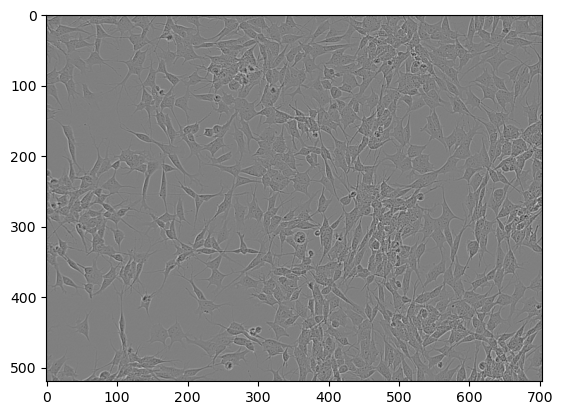

In [190]:
plt.imshow(images[0])

In [191]:
test = images[0]
test = np.expand_dims(test, axis = 0)

In [192]:
prediction = ae_model.predict(test)

1/1 [==============================] - 0s 13ms/step


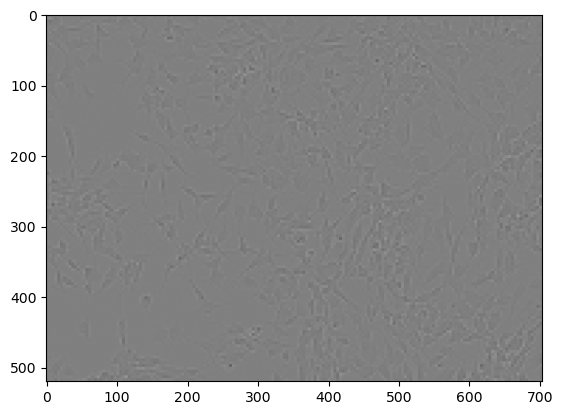

In [193]:
plt.imshow(prediction[0])